# Water Pump Classification Group C

###### Pump it Up: Data Mining the Water Table

In Tanzania, only 57% of the population have access to safe water, and only 30% of them have the facilities to access a decent sanitation. As a consequence, people have to travel long distances to collect water and bring it to their homes. In this country, the demand for water products like tanks, pipes and rain harvesting facilities, is higher than ever.

In this following analysis and considering data from Taarifa and the Tanzanian Ministry of Water, we aim at predicting the pumps that need reparation, that have stopped working and might need replacement, and those that on the contrary, are under perfect conditions. With the ultimate objective of refining the the maintenance operations ensuring high quality of the water across the country, and consequently improving the life quality of citizens in Tanzania.

This document presents a feature engineering and modeling pipeline that includes:

1. Exploratory Data Analysis
2. Baseline Model
3. Feature Engineering Strategies
4. Model Selection
5. CV Results and Business Interpretation
6. Predictions and Final Score in the Data Driven Platform

We have also considered alternatives previously published by different authors as referenced below:

- Feature construction to generate the operational year of the water point. this new feature idea was obtained from: https://medium.com/@vaibhavshukla182/pump-it-up-data-mining-the-water-table-f903d4cfc7a8.

- Feature Engineering categorization: https://zlatankr.github.io/posts/2017/01/23/pump-it-up

The articulation of this project is based on the implementation of the Dataset library enriched with Pandas, Numpy and Sklearn functionalities:

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

from dataset import Dataset
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from copy import copy, deepcopy
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn.preprocessing import MinMaxScaler

## Data Loading

In [2]:
train=  pd.read_csv('train.csv')  
labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')

## EDA

###### Basic data preparation highlights:

-  40 explanatory variables / 1 target ('status_group')
-  Mostly categorical variables and a couple of numerical and datetime features.
-  +46.000 Null values along 7 categorical variables. However, numerical features have many zeros that will requiere attention.
-  Multiple categorical variables with high cardinality, this will imply a frequency analysis to define the encoding and feature engineering strategy. 
- Redundant features containing almost the same categories or information
- Basically we have to deal with highly correlated and under represented variables

###### Dataset Balance: 
The dataset with respect to the target variable is imbalanced:  
54% - Functional / 38% - Non Functional / 7% Functional needs repair. 
We will proceed with the multi-label clasissification approach but it's important to understand that strategies can be applied to deal with the small number of samples of the 3rd class. 

In [ ]:
train.shape
train.isnull().sum()
train.isnull
labels.status_group.value_counts()
for i in train.columns[train.dtypes==object]:
    train[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()

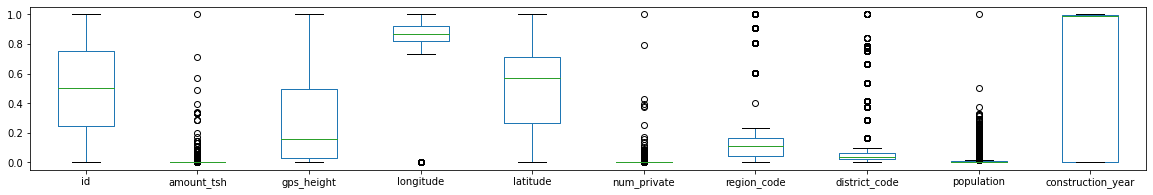

In [3]:
scaler = MinMaxScaler()
Temp = copy(train)
ls= Temp.columns[Temp.dtypes!=object].tolist()
Temp[ls] = scaler.fit_transform(Temp[ls])
Temp[ls].plot(kind='box',figsize=(20,3))

###### Dealing with outliers:

Again, analyzing the numerical variables is important to identify the Installations that probably look different from the others and might skew the model results. Many variables were originally considered as numerical, but we’ll change them to categorical later.

We payed attention to the Population, there seem to be areas with extreme values and the major concentration of samples are located in non-dense areas.
From now on every Feature Engineering procedure will consider the outliers removal to test if the model improves.

## Cross Validation Strategy and Plot Functions


The CV strategy was defined to ensure the correct model evaluation. I implemented 1 CV functions that cover:

1. Randomly split into training and test  to guarantee variability.
2. Oprimal depth of the tree and cost complexity prunning.

In [4]:
Classification_results = {}
Final_Scores = pd.DataFrame(columns=['Model', 'Train_Acc','Test_Acc'])

def cv_classification(X_train, X_test, y_train, y_test, estimator, verbose=False ,Report=False):
    train_scores=[]
    test_scores=[]

    estimator.fit(X_train, y_train)
    train_metric = cross_val_score(estimator, X_train, y_train, cv=10)
    train_scores.append(np.mean(train_metric))
    if verbose is True:
        print('Avg accuracy: {:.3f} +/-{:.3f}'.format(np.mean(train_metric), np.std(train_metric)))
      
    y_pred = estimator.predict(X_test)
    test_score = estimator.score(X_test, y_test)
    test_scores.append(test_score)
   
    if verbose is True:
        print('Accuracy on test: {:.3f}'.format(test_score))
    if Report is True:
        print(classification_report(y_test,y_pred))
    
    return train_scores, test_scores

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.50, ymax=0.99):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    pd.DataFrame(d).set_index([pd.Index(['Training', 'Test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.show()

def features_importance(tree, X):
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(20, 10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
             color="r", align="center")
    index_names = [list(X_train)[i] for i in indices]
    plt.yticks(range(X_train.shape[1]), index_names)
    plt.ylim([-1, X_train.shape[1]])
    plt.xlim([0.0, 0.8])
    plt.show()

## Baseline Definition

The baseline model was generated only by droping the categorical variables mentioned in the EDA process that have a high cardinality and dummifying all the rest of categorical features. Then this dataset was shuffled and splited to be evaluated with the preivously mentioned Cross Validation function with 10 iterations. 

The defined validation metric is accuracy score and the result after cross validation was:  * 0.71 * for the simple tree and * 0.76 * optimizing the depth.



The main problem is dealing with a highly unbalanced classes. That´s why We will pay attention later on to the classification report to understand the performance of our models in terms of precision/recall and the confusion matrix.

- Precision as a meadure of confirmation(how often our model predictions are correct).
- Recall as a measure of utility (how much our model finds what it has to find).

In [5]:
def baseline():
    train=  pd.read_csv('train.csv')  
    labels = pd.read_csv('train_labels.csv')
    Data = copy(train)
    DropCol = ["date_recorded", "funder", "installer", "wpt_name", "subvillage", "ward","scheme_name", "lga"]
    Data = Data.drop(DropCol, axis = 1)
    OneHotCol = Data.columns[Data.dtypes==object]
    Data = pd.get_dummies(Data,prefix=OneHotCol)
    Data = pd.merge(Data, labels, on='id')
    return Data

In [6]:
DF = baseline()

###### Shuffle and Split

In [7]:
DF = DF.sample(frac=1)
X = DF.drop("status_group",axis=1)   
y = DF["status_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Baseline Model - Simple Decision Tree

Considering the large number of categorical variables, we considered that Tree base methods are expected to offer the best results. (Bagging, RF, XGBoost).

Avg accuracy: 0.712 +/-0.007
Accuracy on test: 0.710


<Figure size 576x720 with 0 Axes>

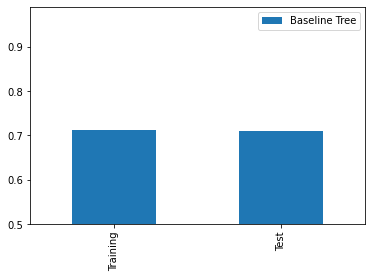

In [8]:
Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=5) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
plot_compare(Classification_results,'Baseline Tree',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Baseline Tree', cv_scores, test_scores]

### Baseline - Optimal Tree Depth

In [9]:
min_depth = 1
max_depth = 30
metric_train = []
metric_test = []

for i in tqdm_notebook(range(min_depth, max_depth)):
    Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=i) 
    train, test = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree)
    metric_train.append(np.median(train))
    metric_test.append(np.median(test))

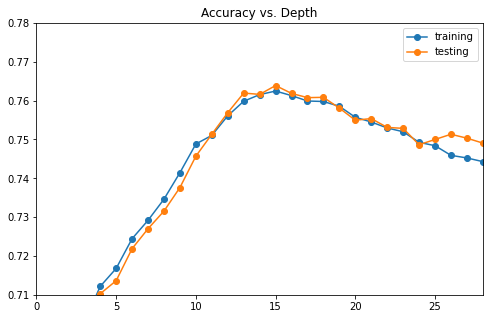

In [14]:
pd.DataFrame(
    {'training': metric_train, 'testing': metric_test}
).plot(legend=True, style='o-', figsize=(8, 5),  title='Accuracy vs. Depth', ylim= (0.71,.78));

Avg accuracy: 0.762 +/-0.008
Accuracy on test: 0.764


<Figure size 576x720 with 0 Axes>

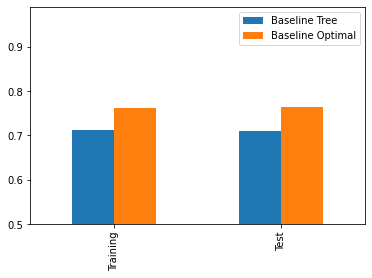

In [15]:
Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=16) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
plot_compare(Classification_results,'Baseline Optimal',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Baseline Optimal', cv_scores, test_scores]

##   Feature Engineering Strategies

For the feature engineering process, this is the approach we followed:

- Date manipulation: We extracted the month and year from the date recorded (the year recorded will be later used for a new feature creation)

- Missing values imputation: We filled the missing values for some categorical features (permit, public meeting) with False for the missing data, and numerical variables (longitude, latitude, gps height, construction year, population) by calculating the mean based on grouping by the district code.

- Feature creation: we created a new feature based on the construction year and recorded year to get how many years to water pump has been operational.

- Dummy categories reduction: From the EDA, we saw that some categorical variables had a lot of categories that were not representative of the data, so we decided to keep the top 5 dominant categories and put the rest as other. The categorical features we changed are: (scheme management, Funder, Installer); however, funder and installer did not improve the model even after this process, so we dropped them.

In [16]:
def Date_Extraction(Data):
    Data["date_recorded"] = pd.to_datetime(Data["date_recorded"])
    Data["year_recorded"] =  Data["date_recorded"].apply(lambda x: x.year)
    Data["month_recorded"] = Data["date_recorded"].apply(lambda x: x.month)
    Categ = ["month_recorded","year_recorded"]
    Data[Categ] = Data[Categ].astype(str)
    return Data

def Missing_Values(Data):
    Data["permit"] = Data["permit"].fillna(False)
    Data["public_meeting"] = Data["public_meeting"].fillna(False) 
    Data[Data["longitude"] == 0]['latitude'] = 0
    LongAVG = Data[Data["longitude"] != 0].groupby(["district_code"])["longitude"].mean()
    LatAVG  = Data[Data["latitude"]  != 0].groupby(["district_code"])["latitude"].mean()
    HeightAVG = Data[Data["gps_height"] != 0].groupby(["district_code"])["gps_height"].mean()
    PopAVG = Data[Data["population"] != 0].groupby(["district_code"])["population"].mean()
    ConstAVG = Data[Data["construction_year"] != 0].groupby(["district_code"])["construction_year"].mean()
    Temp = pd.concat([LongAVG,LatAVG,HeightAVG,PopAVG,ConstAVG], axis=1)
    Temp.columns = ['AVG_Long','AVG_Lat','AVG_Height','AVG_Pop','AVG_Const']
    Data = pd.merge(Data, Temp, left_on=["district_code"], right_index=True, how='left')
    Data['longitude'] = np.where(Data['longitude'] == 0, Data['AVG_Long'],Data['longitude'])
    Data['longitude'] = Data['longitude'].fillna(Data['longitude'].mean())
    Data['latitude'] = np.where(Data['latitude'] == 0, Data['AVG_Lat'], Data['latitude'])
    Data['latitude'] = Data['latitude'].fillna(Data['latitude'].mean())
    Data['gps_height'] = np.where(Data['gps_height'] == 0, Data['AVG_Height'],Data['gps_height'])
    Data['gps_height'] = Data['gps_height'].fillna(Data['gps_height'].mean())
    Data['population'] = np.where(Data['population'] == 0, Data['AVG_Pop'],Data['population'])
    Data['population'] = Data['population'].fillna(Data['population'].mean())
    Data['construction_year'] = np.where(Data['construction_year'] == 0, Data['AVG_Const'],Data['construction_year'])
    Data['construction_year'] = Data['construction_year'].fillna(Data['construction_year'].mean())

    DropCol = Temp.columns.tolist()
    Data = Data.drop(DropCol, axis = 1)

    return Data

def Operational_Year(Data):
    Data['construction_yearM'] = Data['construction_year']
    Data['operational_year'] = Data.year_recorded.astype('int64') - Data.construction_yearM
    Data = Data.drop(['construction_yearM'], axis=1)
    return Data

def Drop_Columns(Data):    
    DropCol = ['date_recorded','amount_tsh',  'num_private', 'region', 'quantity','quality_group', 'source_type', 'payment',
               'waterpoint_type_group','extraction_type_group',"funder", "installer", "wpt_name", "subvillage", 
               "ward","scheme_name", "lga"]    
    Data = Data.drop(DropCol,axis=1)
    return Data
    
def SchemeManagement_Categorization(Data): 
    if Data['scheme_management']=='VWC':
        return 'vwc'
    elif Data['scheme_management']=='WUG':
        return 'wug'
    elif Data['scheme_management']=='Water authority':
        return 'water_authority'
    elif Data['scheme_management']=='WUA':
        return 'wua'
    elif Data['scheme_management']=='Water Board':
        return 'water_board'
    else:
        return 'other'
    
def Funder_Categorization(Data):  
    if Data['funder']=='Government Of Tanzania':
        return 'govern'
    elif Data['funder']=='Danida':
        return 'danida'
    elif Data['funder']=='Hesawa':
        return 'hesawa'
    elif Data['funder']=='Rwssp':
        return 'rwssp'
    elif Data['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'
    
def Installer_Categorization(Data):
    if Data['installer']=='DWE':
        return 'dwe'
    elif Data['installer']=='Government':
        return 'government'
    elif Data['installer']=='RWE':
        return 'rwe'
    elif Data['installer']=='Commu':
        return 'commu'
    elif Data['installer']=='DANIDA':
        return 'danida'
    else:
        return 'other'      
    
def FE1():
    train =  pd.read_csv('train.csv')  
    labels = pd.read_csv('train_labels.csv')
    Data = copy(train)
    Data= Date_Extraction(Data)
    Data= Missing_Values(Data)
    Data['scheme_management'] = Data.apply(lambda row: SchemeManagement_Categorization(row), axis=1)
    Data = Operational_Year(Data)
    Data = Drop_Columns(Data)  
    Categ = ["district_code","region_code"]
    Data[Categ] = Data[Categ].astype(str)
    OneHotCol = Data.columns[Data.dtypes==object]
    Data = pd.get_dummies(Data,prefix=OneHotCol)
    Data = pd.merge(Data, labels, on='id')
    Data = Data.drop(['id'],axis=1)
    return Data

In [17]:
DF = FE1()

###### Shuffle and Split

In [18]:
DF = DF.sample(frac=1)
X = DF.drop("status_group",axis=1)   
y = DF["status_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Modeling

After applying many feature transformations, extraction and creation ideas, we evaluated the improvements with:

- Decision Tree:
    - Decision Tree + CV
    - Decision Tree Depth Optimization + CV
    
- Bagging 
 
- Random Forest:
    - Random Forest + CV 
    - Random Forest Parameter Optimization + CV
    
- Principal Components Analysis + Random Forest + CV 

### Feature Engineering - Simple Decision Tree

Avg accuracy: 0.767 +/-0.006
Accuracy on test: 0.760


<Figure size 576x720 with 0 Axes>

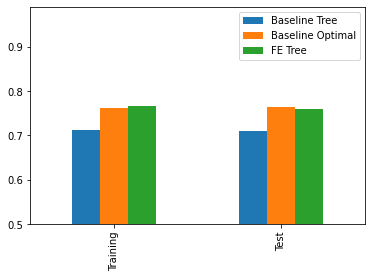

In [19]:
Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=16) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
plot_compare(Classification_results,'FE Tree',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['FE Tree', cv_scores, test_scores]

### Feature Engineering - Optimal Tree Depth

In [20]:
min_depth = 1
max_depth = 30
metric_train = []
metric_test = []

for i in tqdm_notebook(range(min_depth, max_depth)):
    Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=i) 
    train, test = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree)
    metric_train.append(np.median(train))
    metric_test.append(np.median(test))

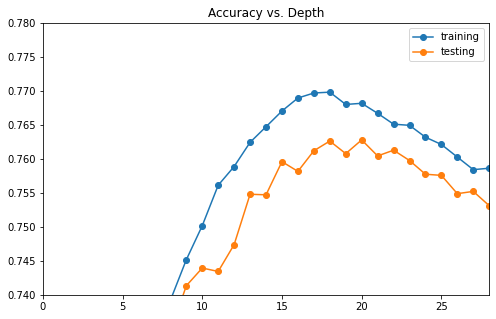

In [27]:
pd.DataFrame(
    {'training': metric_train, 'testing': metric_test}
).plot(legend=True, style='o-', figsize=(8, 5),  title='Accuracy vs. Depth', ylim= (0.74,.78));

Avg accuracy: 0.770 +/-0.007
Accuracy on test: 0.763


<Figure size 576x720 with 0 Axes>

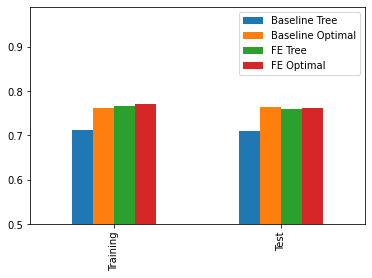

In [28]:
Simple_Tree = DecisionTreeClassifier(random_state=0, max_depth=19) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
plot_compare(Classification_results,'FE Optimal',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['FE Optimal', cv_scores, test_scores]

### Feature Engineering - Bagging

Avg accuracy: 0.803 +/-0.006
Accuracy on test: 0.800


<Figure size 576x720 with 0 Axes>

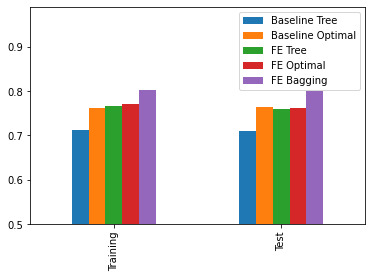

In [29]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=19),n_estimators=100,
                            max_samples=0.5, oob_score=True, random_state=1, n_jobs=-1)

cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,bagging,verbose=True)

plot_compare(Classification_results,'FE Bagging',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['FE Bagging', cv_scores, test_scores]

### Feature Engineering - Random Forest

Avg accuracy: 0.802 +/-0.004
Accuracy on test: 0.799


<Figure size 576x720 with 0 Axes>

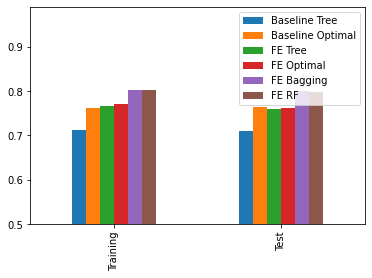

In [30]:
RF = RandomForestClassifier(criterion= 'gini',n_estimators=100, max_features='auto',
                            oob_score = True, random_state=1, n_jobs = -1)

cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,RF,verbose=True)

plot_compare(Classification_results,'FE RF',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['FE RF', cv_scores, test_scores]

### Feature Engineering - Random Forest - Parameter Optimization

In [ ]:
parameters = {"min_samples_split": [3, 5, 7],"min_samples_leaf": [3, 5, 7],"n_estimators" : [400, 500, 700]}

RF = RandomForestClassifier(criterion= 'gini',n_estimators=500, max_features='auto',
                            oob_score = True, random_state=1, n_jobs = -1)

grid_rf = GridSearchCV(RF, parameters, cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)
score = grid_rf.score(X_train, y_train)
best_params = grid_rf.best_params_
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

Avg accuracy: 0.806 +/-0.006
Accuracy on test: 0.801
                         precision    recall  f1-score   support

             functional       0.78      0.92      0.84      6411
functional needs repair       0.64      0.24      0.35       897
         non functional       0.86      0.75      0.80      4572

               accuracy                           0.80     11880
              macro avg       0.76      0.63      0.66     11880
           weighted avg       0.80      0.80      0.79     11880



<Figure size 576x720 with 0 Axes>

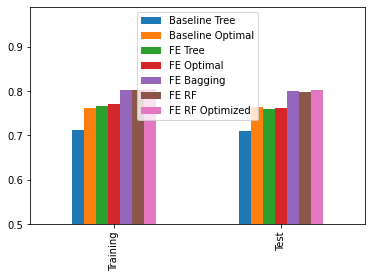

In [31]:
RF = RandomForestClassifier(criterion= 'gini',n_estimators=700,min_samples_leaf= 3, min_samples_split = 3,
                            max_features='auto',oob_score = True, random_state=1,n_jobs = -1)

cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,RF,verbose=True, Report=True)

plot_compare(Classification_results,'FE RF Optimized',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['FE RF Optimized', cv_scores, test_scores]

## Principal Component Analysis

In [33]:
pca = PCA(.95)
Principal_Components = pca.fit_transform(X_train)
X_trainPCA = pca.transform(X_train)
X_testPCA = pca.transform(X_test)
DF2 = pd.DataFrame(data = Principal_Components)

Avg accuracy: 0.612 +/-0.006
Accuracy on test: 0.616


<Figure size 576x720 with 0 Axes>

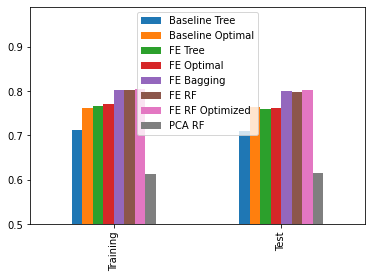

In [35]:
RF = RandomForestClassifier(criterion= 'gini',n_estimators=700,min_samples_leaf= 3, min_samples_split = 3,
                            max_features='auto',oob_score = True, random_state=1,n_jobs = -1)

cv_scores, test_scores = cv_classification(X_trainPCA, X_testPCA, y_train, y_test, RF, verbose = True)

plot_compare(Classification_results,'PCA RF',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['PCA RF', cv_scores, test_scores]

## Results and Business Interpretetation

In [36]:
Final_Scores

,Model,Train_Acc,Test_Acc
1,Baseline Tree,[0.7121632996632997],[0.7102693602693603]
2,Baseline Optimal,[0.7624789562289562],[0.7638888888888888]
3,FE Tree,[0.7670454545454545],[0.7595959595959596]
4,FE Optimal,[0.7698232323232322],[0.7626262626262627]
5,FE Bagging,[0.8034511784511784],[0.8001683501683502]
6,FE RF,[0.8024831649831651],[0.7987373737373737]
7,FE RF Optimized,[0.805513468013468],[0.8012626262626262]
8,PCA RF,[0.6120580808080809],[0.6164141414141414]


###### Model Results:
After several iterations over different feature engineering methods, we were able to outperform the baseline model with a complete data pipeline strategy that allowed our model to achieve a *0.809* accuracy score. 

The main highlights of this process are:
1. The Random Forest after executing Grid Search to get the best Parameters and after a cross validation process generated the best result. 
2. The input for this RF was the result of a complete feature engineering pipeline considering more than 8 feature manipulation, creation and extraction strategies defined as functions in this analysis. The encoding strategy was a One-Hot for categorical features.

###### Business Interpretation:

Predicting the functionality of the pump water wells can optimize both planning and relief efforts within an area. Also applying distance-based methods, we can maybe shutdown some pumps which may not be functional and may repurpose existing pumps to accommodate a greater population and area.

Understanding the final classification report of our model we can expect:

###### Functional pumps:
    - Recall (92%) = We are missing 8% of the pumps that are functional when predicting them with model.
    - Precision (78%) = In 22% of the cases we are including false predictions of pumps that we predict as functional.

###### NON-Functional pumps:
    - Recall (86%) = We are missing 14% of the pumps that are Not working when predicting them.
    - Precision (75%) = In 25% of the cases we predict Non-Functional are false predictions.

###### Functional REPAIR:
    Our model had a hard time capturing this class:
    - Recall (24%) - Precision (35%)

Basically, we are better classifying this problem as a binary situation for Functional and Non-Functional Pumps. This can be improved combining different techniques to deal with imbalanced datasets and better optimized ensemble methods.


## Predictions

In [37]:
def Final_Train():
    train =  pd.read_csv('train.csv')  
    labels = pd.read_csv('train_labels.csv')
    Data = copy(train)
    Data= Date_Extraction(Data)
    Data= Missing_Values(Data)
    Data['scheme_management'] = Data.apply(lambda row: SchemeManagement_Categorization(row), axis=1)
    Data = Operational_Year(Data)
    Data = Drop_Columns(Data)  
    Categ = ["district_code","region_code"]
    Data[Categ] = Data[Categ].astype(str)
    Data = pd.merge(Data, labels, on='id')
    Data = Data.drop(['id'],axis=1)
    return Data

def Final_Test():
    test =  pd.read_csv('test.csv')  
    Data = copy(test)
    Data= Date_Extraction(Data)
    Data= Missing_Values(Data)
    Data['scheme_management'] = Data.apply(lambda row: SchemeManagement_Categorization(row), axis=1)
    Data = Operational_Year(Data)
    Data = Drop_Columns(Data)  
    Categ = ["district_code","region_code"]
    Data[Categ] = Data[Categ].astype(str)
    Data = Data.drop(['id'],axis=1)
    return Data
    
def Encoding(Data):
    OneHotCol = Data.columns[Data.dtypes==object]
    Data = pd.get_dummies(Data,prefix=OneHotCol)
    return Data    

In [38]:
Submission = pd.read_csv('SubmissionFormat.csv')
Train = Final_Train()
Test  = Final_Test()

X = Train.drop("status_group",axis=1)   
y_train = Train["status_group"]

Complete= pd.concat([X,Test])
Complete= Encoding(Complete)

X_train = Complete.iloc[0:59400]
X_test  = Complete.iloc[59400:]

RF = RandomForestClassifier(criterion= 'gini',n_estimators=700,min_samples_leaf= 3, min_samples_split = 3,
                            max_features='auto',oob_score = True, random_state=1,n_jobs = -1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

Submission['status_group']= y_pred
Submission.to_csv("Final_Submission.csv", index = False)

### Final Score - Data Driven

After uploading our Test Predictions to Data Driven, the system scored our model with an acuracy of: 
###### *0.8147*

This results can be verified with the user: 
###### diegoct6